# Логистическая регрессия и регуляризация
Задание курса **Coursera ML with Andrew Ng**. Неделя 3.
Практическая реализация алгоритма логистической регрессии для 1 и более параметров. 
Для подбора оптимальных параметров $ \theta $ будут использоваться алгоритмы *градиентного спуска* и *нормализованного уравнения (normal equation)*, однако теперь с регулированием. 
## Подготовка датасетов

In [2]:
import numpy as np, pandas as pd,matplotlib.pyplot as plt,mpl_toolkits.mplot3d, utils

%cd ~/Documents/ML/machine-learning-ex2/ex2/

# Two-feature dataset. M=99 N=2
dataset_2X = pd.read_csv("ex2data1.txt")

X1 = dataset_2X.to_numpy()[:,0:2].reshape(99,2)
X1 = np.concatenate((np.ones((X1.shape[0],1)),X1),1)
Y1 = dataset_2X.to_numpy()[:,2].reshape(99,1)

# # Two-features dataset. M=117 N=2
dataset_2X2 = pd.read_csv("ex2data2.txt")

X2 = dataset_2X2.to_numpy()[:,0:2].reshape(117,2)
X2 = np.concatenate((np.ones((X2.shape[0],1)),X2),1)
Y2 = dataset_2X2.to_numpy()[:,2].reshape(117,1)

/Users/love/Documents/ML/machine-learning-ex2/ex2


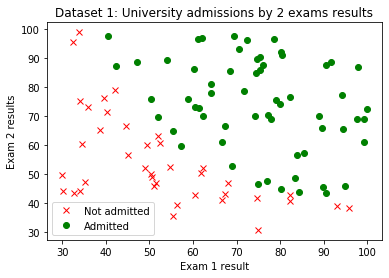

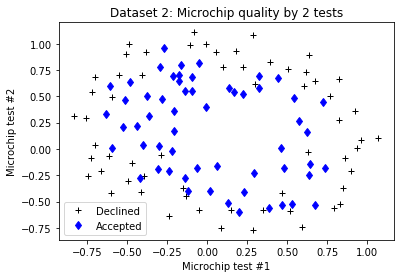

In [195]:
def plotData1(theta = None):
    plt.title("Dataset 1: University admissions by 2 exams results")
    plt.plot(X1[:,1].reshape(99,1)[Y1 == 0],X1[:,2].reshape(99,1)[Y1 == 0],"rx", label = "Not admitted")
    plt.plot(X1[:,1].reshape(99,1)[Y1 == 1],X1[:,2].reshape(99,1)[Y1 == 1],"go", label = "Admitted")
    plt.xlabel("Exam 1 result")
    plt.ylabel("Exam 2 results")
    
    if theta is not None:
        plotDecisionBoundary(X1,Y1,theta)
    plt.legend()
    plt.show()
    
def plotData2(theta = None):
    plt.title("Dataset 2: Microchip quality by 2 tests")
    plt.plot(X2[:,1].reshape(117,1)[Y2 == 0],X2[:,2].reshape(117,1)[Y2 == 0], "k+", label = "Declined")
    plt.plot(X2[:,1].reshape(117,1)[Y2 == 1],X2[:,2].reshape(117,1)[Y2 == 1], "bd", label = "Accepted")
    plt.xlabel("Microchip test #1")
    plt.ylabel("Microchip test #2")
    
    if theta is not None:
        plotDecisionBoundary(X2,Y2,theta)
    plt.legend()
    plt.show()
    
plotData1()
plotData2()

# Стоимостная функцая в логистической регрессии
В задаче классификации нам никак не подходит линейная гипотеза, которую мы использовали ранее, для наиболее адекватных результатов используется сигмоидная гипотеза:
$$ h(x) = g(\theta^T \times X) $$
где _g_ — сигмоидная или логистическая функция
$$ g(z) = \frac{1}{1 + e^{-z}} $$
Отсюда мы можем получить гипотезу, которая в случае классификации будет называться decision boundary

In [3]:
def hypothesis(X, theta):
    return sigmoid(X @ theta)

def sigmoid(z):
    return 1/(1 + np.exp(-1 * z))

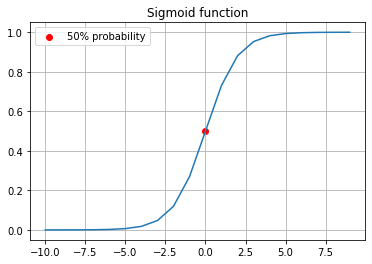

In [114]:
# Sigmoid function visualisation
data = np.arange(-10,10)
plt.plot(data, sigmoid(data))
plt.scatter(0,0.5, color = "r", label = "50% probability")
plt.title("Sigmoid function")
plt.legend()
plt.grid(True)
plt.show()

Так как гипотеза теперь достаточно сложная, использованная ранее стоимостная функция приведет к невыпуклости, и, как следствие, большому количеству локальных минимумов. Это значительно усложнит поиск глобального экстремума, поэтому мы подберем подходящую форму:
$$ J(\vec{\theta}) = \frac{1}{m} \sum \limits _{i=1} ^{m} [-y^{(i)} \log(h_\theta(x^{(i)})) - (1-y^{(i)}) \log(1 - h_\theta(x^{(i)}))] $$
Также достаточно практичным решением было бы передавать производную вместе с ошибкой:
$$ \frac{\partial J(\vec{\theta)}}{\partial \theta_j} = \frac{1}{m} \sum \limits _{i=1} ^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$$

Также можно опционально ввести регуляризацию — она минимизирует и сами параметры $ \Theta $, тем самым оптимизируя кривую:
$$ J(\vec{\theta}) = \frac{1}{m} \sum \limits _{i=1} ^{m} [-y^{(i)} \log(h_\theta(x^{(i)})) - (1-y^{(i)}) \log(1 - h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum \limits _{j=1} ^{n} \theta_j^2$$
Стоит заметить, что оптимизация нулевого параметра не производиться, так как он никак не влияет на кривизну или сложность функции. Для дифференциального уравнения добавление регуляризации несколько изменит вид:
$$ j=0 \Rightarrow \frac{\partial J(\vec{\theta})}{\partial \theta_0} = \frac{1}{m} \sum \limits _{i=1} ^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} $$
$$ j>0 \Rightarrow \frac{\partial J(\vec{\theta})}{\partial \theta_j} = [\frac{1}{m} \sum \limits _{i=1} ^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}] + \frac{\lambda}{m}\theta_j $$

In [4]:
def cost(X,y,theta, regularization = None):
    m = X.shape[0]
    h = hypothesis(X,theta)
    errs = -y * np.log(h) - (1 - y) * np.log(1 - h)
 
    if regularization != None:
        J_reg = regularization / (2*m) * np.sum(theta[1:]**2)
        theta_shadow = theta
        theta_shadow[0] = 0
        print(theta_shadow)
        d_reg = (regularization / m) * theta_shadow
    else:
        J_reg = 0
        d_reg = 0
    
    J = 1 / m * np.sum(errs) + J_reg
    dtheta = (1 / m * (h - y).T @ X) + d_reg
    return J, dtheta.T

In [5]:
theta = np.zeros((X1.shape[1],1))
J, dth = cost(X1,Y1,theta)
print("1. Cost function for first dataset is %.3f" %J)

theta2 = np.zeros((X2.shape[1],1))
J,dth = cost(X2,Y2,theta2)
print("2. Cost function for the second dataset is %.3f" %J)

1. Cost function for first dataset is 0.693
2. Cost function for the second dataset is 0.693


# Градиентный спуск
Применим уже знакомый способ оптимизации параметров. Здесь, ввиду того, что мы уже извлекли производную в стоимостной функции, алгоритм практически идентичен прошлому:

In [6]:
def gradient_descent(X, y, theta, alpha, num_iters, regulator = None):
    m = X.shape[0]
    J = 0
    J_history = np.zeros((num_iters,1))
    
    for i in range(num_iters):
        J, delta = cost(X,y,theta, regulator)
        theta = theta - alpha * delta
        J_history[i] = J
    return (J, J_history,theta)

In [ ]:

theta = np.array([[-20],[-20],[-20]])
J, history, theta1 = gradient_descent(X1,Y1,theta, 0.001,1000)
print("1. Final J for the first dataset is %.3f, final parameters are %s" %(J, theta1.T))
utils.draw_J_history(history)
plotData1(theta1)

1. Final J for the first dataset is 0.209, final parameters are [[-19.73007358   0.16218376   0.15845109]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


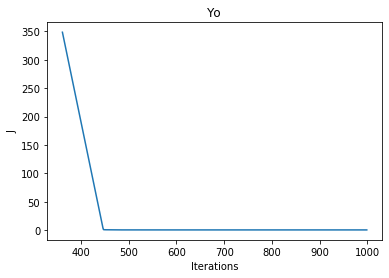

NameError: name 'plotData1' is not defined

In [12]:
theta = np.array([[-20],[-20],[-20]])
J, history, theta1 = gradient_descent(X1,Y1,theta, 0.001,1000)
print("1. Final J for the first dataset is %.3f, final parameters are %s" %(J, theta1.T))
utils.draw_J_history(history)
plotData1(theta1)

## Полиномиальные параметры, искривление гипотезы
Чтобы создать кривую, больше подходящую для второго датасета нужно создать псевдо-фичи, которые являются степенными значениями изначальных 2 фич. Выбор степени сложности гипотезы произвольный, здесь возьмем повышение вплоть до 6 степени. Таким образом, наша гипотеза преобразиться:
$$ h(X) = \theta_0 + \theta_1x_1 + \theta_2x_2 \Longrightarrow h(X) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_1^2 + \theta_4x_1x_2 + \theta_5x_2^2 + \theta_6x_1^3 + ... + \theta_{27}x_1x_2^5 + \theta_{28}x_2^6 $$

1. Final J for the first dataset is 0.690, final parameters are [[-0.02526914 -0.30848717 -0.05288192]]


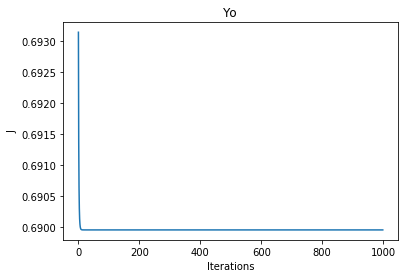

In [214]:
theta = np.array([[0],[0],[0]])
J, history, theta1 = gradient_descent(X2,Y2,theta, 5,1000)
print("1. Final J for the first dataset is %.3f, final parameters are %s" %(J, theta1.T))
utils.draw_J_history(history)
# plotData1(theta1)

Однако чтобы построить decision boundary выше, нужно определить кривую: в случае прямой это тривиально, при этом параметры оси X найти просто: возьмем минимальное и макстмальное значение, и подберем для них значения на оси ординат:
$$ y(x) = \frac{-1}{\theta_2}( \theta_1 x + \theta_0) $$
Таким образом мы получили массив 2х2, который равномерно заполнит область полотна.

In [192]:
def plotDecisionBoundary(X,Y,theta):
    POSITIVE_COL = 1
    x = np.array([np.amin(X[:,POSITIVE_COL] -2),np.amax(X[:,POSITIVE_COL] + 2)])
    y = (-1/theta[2])*(theta[1] * x + theta[0])
    print(y)
    plt.plot(x,y, label = "Decision boundary")